In [65]:
import  pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split



In [66]:
df = pd.read_csv("data.csv")

In [67]:
def categorize_air_quality(value):
    if value <= 50:
        return 'Good'
    elif 51 <= value <= 100:
        return 'Moderate'
    elif 101 <= value <= 150:
        return 'Unhealthy for Sensitive Groups'
    elif 151 <= value <= 200:
        return 'Unhealthy'
    else:
        return 'Hazardous'

In [68]:
df['Air Quality'] = df['Air Quality'].apply(categorize_air_quality)

In [69]:
df.isna().sum()


CO2            0
TVOC           0
PM10           0
PM2.5          0
CO             0
Air Quality    0
LDR            0
O3             0
Temp           0
Hum            0
ts             0
dtype: int64

In [70]:
df['Air Quality'].value_counts()

Air Quality
Moderate                          255994
Unhealthy                         174047
Unhealthy for Sensitive Groups     89972
Good                               43768
Hazardous                          26095
Name: count, dtype: int64

In [71]:
import numpy as np

# Select numerical columns
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Create a copy of the dataframe
df2 = df.copy()

# Initialize a variable to track the number of rows
previous_rows = df2.shape[0]

while True:
    # Calculate Q1, Q3, and IQR for numerical columns
    Q1 = df2[num_cols].quantile(0.25)
    Q3 = df2[num_cols].quantile(0.75)
    IQR = Q3 - Q1

    # Define outlier thresholds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identify outliers
    outliers = ((df2[num_cols] < lower_bound) | (df2[num_cols] > upper_bound))

    # Remove rows with any outliers
    df2 = df2[~outliers.any(axis=1)]

    # Check the current number of rows
    current_rows = df2.shape[0]

    # If no rows were removed, stop the loop
    if current_rows == previous_rows:
        break
    
    # Update previous_rows for the next iteration
    previous_rows = current_rows

# df2 now contains the dataset with all outliers removed

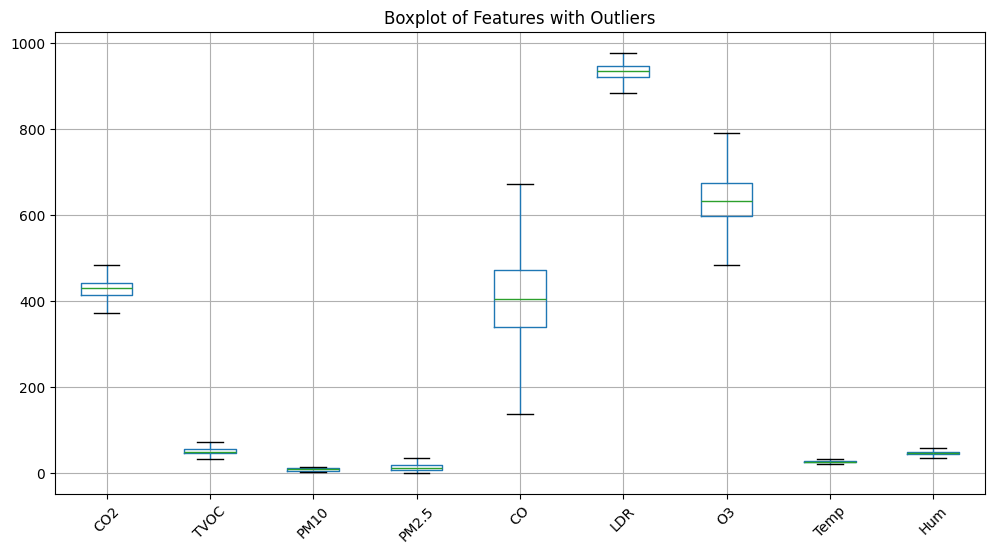

In [72]:
# Draw boxplots
plt.figure(figsize=(12, 6))
df2[num_cols].boxplot(rot=45)
plt.title("Boxplot of Features with Outliers")
plt.show()

In [73]:
df2.head()

,CO2,TVOC,PM10,PM2.5,CO,Air Quality,LDR,O3,Temp,Hum,ts
4375,400,45,5.45,29.7,284,Unhealthy for Sensitive Groups,978,510,26.2,39.5,2024-05-26T08:53:0
14912,406,48,9.31,7.6,171,Unhealthy for Sensitive Groups,975,512,25.0,50.7,2024-06-15T14:02:0
17262,400,42,11.58,3.8,383,Unhealthy,961,554,24.6,44.6,2024-06-19T22:49:2
17585,400,42,4.78,13.9,244,Unhealthy for Sensitive Groups,961,490,24.7,38.4,2024-06-20T04:12:1
21764,428,47,2.65,15.4,246,Unhealthy for Sensitive Groups,976,566,25.4,47.7,2024-06-29T16:33:3


In [74]:
df2.set_index("ts", inplace=True)  # Set timestamp as index

df2 = df2[df2.index< "2026-01-01"]

df2['ts'] = pd.to_datetime(df2.index, errors='coerce')
df2['month'] = df2['ts'].dt.month
df2.drop(axis=1, columns="ts", inplace=True)

In [75]:
def scale_features(data, scaler=None):
    """
    Scales features using StandardScaler. If a scaler is provided, it transforms the data;
    otherwise, it fits and transforms the data using a new StandardScaler instance.
    
    Parameters:
    X_train (array-like): Feature matrix.
    scaler (StandardScaler, optional): Pre-fitted StandardScaler instance. Defaults to None.
    
    Returns:
    X_train_scaled (np.array): Scaled feature matrix.
    scaler (StandardScaler): StandardScaler instance used.
    """
    if scaler is None:
        scaler = StandardScaler()
        data_scaled = scaler.fit_transform(data)
    else:
        data_scaled = scaler.transform(data)
    
    return data_scaled, scaler

In [76]:

def encode_labels(y):
    """
    Encodes categorical labels into integers and ensures a 1D array.
    
    Parameters:
    y_train (array-like): Original labels.
    
    Returns:
    y_train_encoded (np.array): Encoded 1D array of labels.
    label_encoder (LabelEncoder): Fitted LabelEncoder instance.
    """
    y = np.ravel(y)  # Ensure 1D
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    
    return y_encoded.squeeze(), le

In [77]:
X=df2.drop(axis=1,columns="Air Quality")
y=df2[["Air Quality"]]
y_encoded, y = encode_labels(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

X_train, scaler = scale_features(X_train)
X_test = scale_features(X_test, scaler=scaler )

In [78]:
X_train.shape, y_train.shape

((238865, 10), (238865,))

In [79]:
import numpy as np

def generate_sequences(X_train, y_train_encoded, sequence_length=60, target_length=60):
    X_sequences = []
    y_sequences = []
    
    for i in range(len(X_train) - sequence_length - target_length + 1):
        X_sequences.append(X_train[i:i+sequence_length])
        y_sequences.append(y_train_encoded[i+sequence_length:i+sequence_length+target_length])
    
    return np.array(X_sequences), np.array(y_sequences)

In [80]:
X_sequences, y_sequences = generate_sequences(X_train, y_train)

In [81]:
X_sequences.shape, y_sequences.shape

((238746, 60, 10), (238746, 60))

In [82]:
# y_train = np.ravel(y_train)  # or y_train = y_train.flatten()

# Compute class weights on the encoded labels
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i: float(w) for i, w in enumerate(class_weights)}

print(class_weights)

{0: 4.360839799178457, 1: 7.909437086092716, 2: 0.3946159818935752, 3: 0.6797911093403153, 4: 1.5646862308397746}


In [83]:
X_sequences.shape, y_sequences.shape

((238746, 60, 10), (238746, 60))

In [84]:
import tensorflow as tf 
# Convert to tensors
X_train_tensor = tf.convert_to_tensor(X_sequences, dtype=tf.float16)
y_train_tensor = tf.convert_to_tensor(y_sequences, dtype=tf.int8)

# Model building

- using X_tensor (298463, 60, 10), y_tensor (298463, 60) for modeling 

In [91]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv1D, LSTM, Bidirectional, TimeDistributed, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

num_classes = len(df2['Air Quality'].unique())  # Number of air quality categories
sequence_length = 60  # Input timesteps
target_length = 60    # Output timesteps
no_features = 10

model = Sequential([
    Input(shape=(sequence_length, no_features)),  # Input shape remains the same
    
    # CNN layers for feature extraction
    Conv1D(64, kernel_size=3, activation='relu', padding='same'),
    
    # Bidirectional LSTM layers
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(64, return_sequences=True)),
    
    # Final dense layers with TimeDistributed
    TimeDistributed(Dense(128, activation='relu')),
    TimeDistributed(Dense(num_classes, activation='softmax'))
])
optimizer = Adam(learning_rate=0.01)

model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [92]:
# Create a sample_weight array with the same shape as y_tensor
sample_weight = np.ones_like(y_train_tensor, dtype=np.float32)

callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True)  
]

# Apply class weights per timestep
for cls, weight in class_weights.items():
    sample_weight[y_train_tensor == cls] = weight

history = model.fit(
    X_train_tensor,
    y_train_tensor,
    validation_split=0.1,
    epochs=5,
    verbose=1,
    batch_size=256,
    sample_weight=sample_weight,
    callbacks=callbacks
)

2025-03-13 01:26:56.517516: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 515690400 exceeds 10% of free system memory.


Epoch 1/5
840/840 ━━━━━━━━━━━━━━━━━━━━ 36s 38ms/step - accuracy: 0.1558 - loss: 1.5379 - val_accuracy: 0.2506 - val_loss: 3.2642
Epoch 2/5
840/840 ━━━━━━━━━━━━━━━━━━━━ 32s 38ms/step - accuracy: 0.4123 - loss: 0.7286 - val_accuracy: 0.2844 - val_loss: 4.2132
Epoch 3/5
197/840 ━━━━━━━━━━━━━━━━━━━━ 24s 38ms/step - accuracy: 0.5243 - loss: 0.5548

KeyboardInterrupt: 

In [448]:
sample = 100000

X_tensor_reshaped = tf.expand_dims(X_tensor[sample], axis=0)  # Shape becomes (1, 60, 10)
predictions = model.predict(X_tensor_reshaped)
int_predictions = np.round(predictions).astype(int)

# Convert one-hot encoded predictions to class indices
class_indices = np.argmax(int_predictions, axis=-1)  # Shape: (1, 60)

# Flatten the array (remove batch dimension) if needed
class_indices = class_indices.flatten()  # Shape: (60,)
class_predictions = le.inverse_transform(class_indices)
class_predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


array(['Unhealthy', 'Unhealthy', 'Hazardous', 'Unhealthy', 'Unhealthy',
       'Unhealthy', 'Unhealthy', 'Unhealthy', 'Unhealthy', 'Unhealthy',
       'Unhealthy', 'Unhealthy', 'Unhealthy', 'Unhealthy', 'Unhealthy',
       'Unhealthy', 'Unhealthy', 'Unhealthy', 'Unhealthy', 'Unhealthy',
       'Unhealthy', 'Unhealthy', 'Hazardous', 'Hazardous', 'Hazardous',
       'Hazardous', 'Unhealthy', 'Unhealthy', 'Unhealthy', 'Unhealthy',
       'Unhealthy', 'Unhealthy', 'Unhealthy', 'Unhealthy', 'Unhealthy',
       'Unhealthy', 'Unhealthy', 'Unhealthy', 'Unhealthy', 'Unhealthy',
       'Unhealthy', 'Unhealthy', 'Unhealthy', 'Unhealthy', 'Unhealthy',
       'Unhealthy', 'Unhealthy', 'Unhealthy', 'Unhealthy', 'Unhealthy',
       'Unhealthy', 'Unhealthy', 'Unhealthy', 'Unhealthy', 'Unhealthy',
       'Unhealthy', 'Unhealthy', 'Unhealthy', 'Unhealthy', 'Unhealthy'],
      dtype=object)

In [449]:
class_predictions = le.inverse_transform(y_tensor[sample+60])
class_predictions

array(['Unhealthy', 'Unhealthy', 'Unhealthy', 'Unhealthy', 'Unhealthy',
       'Unhealthy', 'Unhealthy', 'Unhealthy', 'Unhealthy', 'Unhealthy',
       'Unhealthy', 'Unhealthy', 'Unhealthy', 'Unhealthy', 'Unhealthy',
       'Unhealthy', 'Unhealthy', 'Unhealthy', 'Unhealthy', 'Unhealthy',
       'Unhealthy', 'Unhealthy', 'Unhealthy', 'Unhealthy', 'Unhealthy',
       'Unhealthy', 'Unhealthy', 'Unhealthy', 'Unhealthy', 'Unhealthy',
       'Unhealthy', 'Unhealthy', 'Unhealthy', 'Unhealthy', 'Unhealthy',
       'Unhealthy for Sensitive Groups', 'Unhealthy', 'Unhealthy',
       'Unhealthy', 'Unhealthy', 'Unhealthy', 'Unhealthy', 'Unhealthy',
       'Unhealthy', 'Unhealthy', 'Unhealthy', 'Unhealthy', 'Unhealthy',
       'Unhealthy', 'Unhealthy', 'Unhealthy', 'Unhealthy', 'Unhealthy',
       'Unhealthy', 'Unhealthy for Sensitive Groups',
       'Unhealthy for Sensitive Groups', 'Unhealthy for Sensitive Groups',
       'Unhealthy for Sensitive Groups', 'Unhealthy for Sensitive Groups',
       'U